# Predicting Interview No-shows

**Problem statement:**

Your company, Acme Co., sources candidates for companies hiring new employees. Recently, a number of our clients have complained that candidates have not been showing up to interviews. Your boss has provided you with the attached data set in hopes that you can find some way of identifying candidates at risk of not attending scheduled interviews

Logistic regression or a tree-based method. It seems like there are a good amount of categorical features, so may be learning towards trees.

**Import Libraries:**

In [370]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import re
import pickle
import googlemaps 
from datetime import datetime
import itertools
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

**Functions:**

In [400]:
def clean_special_characters(string):
    l = re.sub('[^A-Za-z0-9]+', ' ', string)
    return l.strip()

def get_city_diff(city_1,city_2):
    distance = gmaps.distance_matrix(city_1,city_2)['rows'][0]['elements'][0]
    return distance['distance']['value']

def replace_value(val,replacable_words_li,replace_word):
    if val in replacable_words_li:
        return replace_word
    else: 
        return val
    
def get_date_string(date):
    val = re.search("^(\d)+[\.\-\/](\d)+[\.\-\/](\d)*",date).group()
    val = val.replace("/",'.').replace("-",".")
    d,m = val.split('.')[0].zfill(2),val.split('.')[1].zfill(2)
    if len(val.split('.')[2]) == 4:
        yr = val.split('.')[2]
    else:
        yr = "20".join(val.split('.')[2])
    return ".".join([d,m,yr])
    
def clean_date_formating(row):
    try:
        date = get_date_string(row)
        return datetime.strptime(date, '%d.%m.%Y')
    except:
        date = '.'.join([row[:2],'04.2016'])
        return datetime.strptime(date, '%d.%m.%Y')
        
    
def format_date(row):
    r = clean_date_formating(row)
    
    if int(r.split('.')[0]) <= 12 and int(r.split('.')[1]) <= 12:
        return "both_under"
    elif int(r.split('.')[0]) > 12:
        return "d-m-y"
    elif int(r.split('.')[1]) > 12: 
        return "m-d-y"
    else:
        return "other"
    
def clean_locations(locale):
    return locale.replace("-",'').split('/')[0].strip().replace("-",'')

def clean_col_vals(row,value_replacements):
    if row in value_replacements.keys():
        return value_replacements[row].replace(' ','_')
    else:
        return row.replace(' ','_')
    
def clean_position_names(row):
    return row.replace('-','').replace(' ','_')

def replace_time_with_position(skills,position):
    try:
        re.search("(\d)+[\.](\d{2}\s)[\w]{2}",skills).group()
        return position
    except:
        return skills
    
def lead_or_manager_skills_fix(skills,position,position_or_lead="position"):
    ptrn = "[\_]?(senior|manager|lead|sr|tech_lead|technical_lead)[\_]?"
    try:
        s = re.search(ptrn,skills).group()
        if (s == skills) and position_or_lead=="position":
            return position
        elif position_or_lead!="position":
            return 1
        else:
            return skills.replace(s,'')
    
    except:
        if position_or_lead=="position":
            return skills
        else: 
            return 0

def clean_col_vals_new(row,value_replacements):
    if row == "basesas program/ reporting":
        return "basesas_program_reporting"
    for val in value_replacements.keys():
        if row in value_replacements[val]:
            val.split(',')
            v=val.strip().replace('-',' ')
            s = re.sub(' +', ' ', v)
            return s.replace(' ','_')
        else:
            pass
    
    if row.find(',') != -1:
        row = '/'.join([x.strip() for x in row.split(',')])
    
    v = row.replace('-',' ').replace("–"," ").strip()
    s = re.sub(' +', ' ', v) 
    return s.replace(' ','_')

def value_contained_skill(skill,val):
    for v in val:
        if skill.find(v) != -1:
            return 1
        else: 
            return 0
    
def clean_skills(skills):
    for s in ['/',',','–','-','(',')']:
        skills = '_'.join([i.strip() for i in skills.split(s) if i != ''])

    return skills.lower().replace('&',' and ').replace(' ','_').replace("__","_")

def replace_skills(skill,replacements):
    for key in skill_replacements.keys():
        if skill in skill_replacements[key]:
            return key
        else: 
            pass
        
    return skill

def clean(val):
    return val.replace(", India","")

def get_distance(city_1,city_2,updated_distances):
    try:
        try:
            if city_1 == city_2:
                return 0
            elif city_1[1] > city_2[1]:
                return updated_distances[city_1][city_2]
            elif city_1[1] < city_2[1]:
                return updated_distances[city_2][city_1]
            else: 
                return updated_distances[city_1][city_2]
        except:
            return updated_distances[city_2][city_1]
    except:
        return get_city_diff(city_1,city_2)

def zeros_and_ones(res):
    if res == "no":
        return 0
    else: 
        return 1
    
def confusion_data(row):
    r_comf = 'Have you obtained the necessary permission to start at the required time_yes'
    if row[r_comf] == 0 and row["y"] == 0:
        return "true_neg"
    elif row[r_comf] == 1 and row["y"] == 0:
        return "false_pos"
    elif row[r_comf] == 1 and row["y"] == 1:
        return "true_pos"
    else:
        return "true_neg"
    
def get_prob(outcome):
    if outcome == 1:
        return 0.69
    else:
        return 0.31


Read in the data:

In [372]:
data = pd.read_csv("Interview_Input.csv")

In [496]:
grab_these = pd.read_csv("Interview_Input.csv")

grab_these.drop(['Unnamed: 22','Unnamed: 23','Unnamed: 24','Unnamed: 25','Unnamed: 26'],axis=1,inplace=True)
grab_these.dropna(subset=["Date of Interview"],inplace=True)
here = grab_these[["Name(Cand ID)","Observed Attendance"]]

### Data Cleaning:

We now need to look for missing values, data types, correlations, etc. First let's deal with missing values.

Drop read in empty columns:

In [373]:
data.drop(['Unnamed: 22','Unnamed: 23','Unnamed: 24','Unnamed: 25','Unnamed: 26'],axis=1,inplace=True)

In [374]:
# data.isnull().sum()

for the missing date item, I may just drop. Once checking it (show below), we can see that the entire row is missing, so this one will be dropped:

In [375]:
data[data['Date of Interview'].isnull()]

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Candidate Native location,Have you obtained the necessary permission to start at the required time,Hope there will be no unscheduled meetings,Can I Call you three hours before the interview and follow up on your attendance for the interview,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much,Have you taken a printout of your updated resume. Have you read the JD and understood the same,Are you clear with the venue details and the landmark.,Has the call letter been shared,Observed Attendance,Marital Status
1233,NaN,﻿﻿,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [376]:
data.dropna(subset=["Date of Interview"],inplace=True)

Ok, lets look at the values in these binary columns. There seems to be some issues with input values. The values need to be cleaned. So, let's look into the column values to clean them proplerly. First, let's lower all of values.

In [377]:
for col in data.columns:
    data[col] = data[col].str.lower()
    data[col] = data[col].str.strip()

I'm making a dictionary with all columns values, except for dates and names: 

In [378]:
col_vals_2 = {}

for col in data.columns:
    if col in ["Date of Interview","Name(Cand ID)"]:
        pass
    else:
        col_vals_2[col] = data[col].value_counts().keys().to_list()

Update values for the question based answers:

In [379]:
cols_for_maybe = ['Has the call letter been shared','Hope there will be no unscheduled meetings']
    
cols_for_YN = ['Are you clear with the venue details and the landmark.',
               'Have you taken a printout of your updated resume. Have you read the JD and understood the same',
               'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much',
               'Can I Call you three hours before the interview and follow up on your attendance for the interview',
               'Have you obtained the necessary permission to start at the required time']

vals_for_maybe_dict = ['need to check','not yet','havent checked','yet to check','cant say']

vals_for_YN = ['no- i need to check','not yet','no- will take it soon','no',
               'no i have only thi number','no','no dont','not yet','yet to confirm']

for col in cols_for_maybe:
    data[col] = data[col].apply(lambda val: replace_value(val,vals_for_maybe_dict,"not sure"))
    
for col in cols_for_YN:
    data[col] = data[col].apply(lambda val: replace_value(val,vals_for_YN,"no"))
    
#replace_value(val,replacable_words_li,replace_word

There is a string value that is "na". In a way to understand if it is meant to be read as "N/A" or an accident for "no", I've pulled the data where this value shows up. 

For most of the columns, it is showing up for the 20 same rows (found using `data[data['Hope there will be no unscheduled meetings']=='na']`). I looked to see what is common about these rows to determine if there are any commonaility that would make it sensible to be N/A or if it should be no. However, I think based on the commonaility across the board, I'm leaning to it falling into the NaN category. I will most likely assign it as such, and deal with null values after one-hot encoding.

I now need to address the formatting issues with the date column. Some values are separated differently. A few list date and time, while others start with months as the first value. Below we will figure out how we can manage these and fix them.

was used before but isn't now:

`data["date_formats"] = data["Date of Interview"].apply(lambda row: format_date(row))`
`data["date_formats"].value_counts()`

based on this, I am assuming a format of "dd/mm/yyyy"

In [380]:
data["Date of Interview"] = data["Date of Interview"].apply(lambda row: clean_date_formating(row))

Based on the fact this model is forward looking, I'm going to **not going to use the year** in training our model. We will have a separate month and day column. But we will do this after cleaning the rest of the data.

Next clean all location values: 

In [381]:
for col in ['Location','Candidate Current Location','Candidate Job Location',
            'Interview Venue','Candidate Native location']:
    data[col] = data[col].apply(lambda loc: clean_locations(loc))

fix values that need to be replaced:

In [382]:
industry_replacements = {'it products and services':'it','it services':'it'}
interview_type_replacements = {'scheduled walk in':'scheduled_walkin','scheduled walkin':'scheduled_walkin',
                              'sceduled walkin':'scheduled_walkin'}
client_replacements = {"aon hewitt gurgaon":"aon","aon hewitt":"aon","hewitt":"aon",
                       "standard chartered bank chennai":"standard chartered bank"}

data['Industry'] = data['Industry'].apply(lambda row: clean_col_vals(row,industry_replacements))
data['Interview Type'] = data['Interview Type'].apply(lambda row: clean_col_vals(row,interview_type_replacements))
data["Position to be closed"] = data["Position to be closed"].apply(lambda row: clean_position_names(row))
data['Client name'] = data['Client name'].apply(lambda row: clean_col_vals(row,client_replacements))

Look into skillsets to determine how we can make more out of this data. There's a lot of data in each cell, we can break them down more to better use the data.

first thing, if there is a time in the skillset just put the `Position to be closed` value:

In [383]:
data["Nature of Skillset"] = data.apply(lambda row: replace_time_with_position(row["Nature of Skillset"],row["Position to be closed"]),axis=1)

Clean up some of these skills:

In [384]:
data["skillset"] = data['Nature of Skillset'].apply(lambda row: clean_skills(row))
data["is_lead_or_manager"] = data.apply(lambda row: lead_or_manager_skills_fix(row['Nature of Skillset'],row['Position to be closed'],position_or_lead="lead"),axis=1)
data["skillset"] = data.apply(lambda row: lead_or_manager_skills_fix(row["skillset"],row['Position to be closed'],position_or_lead="position"),axis=1)

In [385]:
skill_replacements = {"java_j2ee_struts_hibernate_spring_jsf_xml":["java_j2ee_struts_hibernate","java_spring_hibernate_jsf",
                        "java_j2ee","java_spring_hibernate","java_j2ee_core_java","java_jsf","java_j2ee_jsf",
                        "java_xml_struts_hibernate"],
                        "java_developer":["java","core_java","java_sql"],
                        "cdd_kyc":["aml_kyc_cdd"],
                        "lending_and_liabilities":["l_and_l","lending_and_liablities"],
                        "biosimillar":["biosimilars"],
                        "oracle":["oracle_plsql"],
                        "label":["ra_label","global_labelling"],"cots":["cots_developer"]
                     }
    
tester = data['skillset'].apply(lambda row: replace_skills(row,skill_replacements))

get posts that are for manager,senior, or lead positions:

In [386]:
skill_replacements = {"lending_and_liabilities":["l_and_l","lending_and_liability"],
                      "biosimillar":["biosimilars"],
                      "etl":["tl"]
                     }
    
data['skillset'] = data['skillset'].apply(lambda row: replace_skills(row,skill_replacements))

In [387]:
role_values = {"java":["java"],"j2ee":["j2ee"],"hibernate":["hibernate"],
               "jsf":["jsf"],"spring":["spring"],"sql":["sql","ms_exchange"],
               "sas":["sas"],"sccm":["sccm"],"aml":["aml"],"ra":["ra"],
               "developer":["developer","software_engineer"],"testing":["testing"],
               "production":["production"],"mednet":["mednet"],"operations":["operations"],
               "cots":["cots"],"oracle":["oracle"],"analytics":["analy"],"regulatory":["regulatory"],
               "hadoop":["hadoop"],"automation":["automation"],"label":["label"],"fresher":["fresher"],
               "cdd_kyc":["cdd_kyc"],"dot_net":["dot_net"],"emea":["emea"],"routine":["routine"],
               "lending_and_liabilities":["lending_and_liabilities"],"biosimillar":["biosimillar"],
               "etl":["etl"],"publishing":["publishing"],"#name?":["#name?"],
                 "support":["support"],"network":["network"]}

let's get all of the values to make individual columns:

In [388]:
for val in role_values.keys():  
    col_name = f"{val}_role"
    data[col_name] = data.skillset.apply(lambda skill: value_contained_skill(skill,role_values[val]))

ok, now to fill in null values.

The "na" value in pandas are read already as null values. no need to run the following to impute them to nan:

```
cols = ['Are you clear with the venue details and the landmark.',
        'Have you taken a printout of your updated resume. Have you read the JD and understood the same',
        'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much',
        'Can I Call you three hours before the interview and follow up on your attendance for the interview',
        'Have you obtained the necessary permission to start at the required time',
        'Has the call letter been shared','Hope there will be no unscheduled meetings']

for i in cols:
    data[i] = data[i].replace(to_replace='na', value=None)
    print(data[i].unique())`
```

for simplicities sake of this challenge I will be filling the missing values with the mode values. XGBoost is an option to use in a case like this as well, but to be more intreprtable, we're going to continue with this methid.

I will be removing the row from the DataFrame that do not have values in the dependent variable.

In [389]:
l = data.isnull().sum()
l = pd.DataFrame(l)
na_columns = l[l[0] > 0].index.to_list()

In [390]:
na_columns.pop(-1)

'Observed Attendance'

In [391]:
for col in na_columns:
    val_to_fill = data[col].mode()[0]
    data[col] = data[col].fillna(val_to_fill)

I will be dropping here are: `Nature of Skillset`,`Location`

In [392]:
data.drop(["Nature of Skillset","Location"],axis=1,inplace=True)

get month and day extracted from `Date of Interview`, then drop the column:

In [393]:
data["month"] = data["Date of Interview"].apply(lambda date: date.month)
data["day"] = data["Date of Interview"].apply(lambda date: date.day)
data["day_of_year"] = data["Date of Interview"].apply(lambda date: date.timetuple().tm_yday)

In [394]:
data.drop(["Date of Interview"],axis=1,inplace=True)

Now to deal with options for locations so we can remove some of these categorical values. We will use the google api to get values for the following:
    
distance between:
- `Candidate Current Location` from `Candidate Job Location`
- `Candidate Current Location` from `Interview Venue`
- `Candidate Current Location` from `Candidate Native location`
- `Candidate Job Location` from `Interview Venue`
- `Candidate Job Location` from `Candidate Native location`
- `Interview Venue` from `Candidate Native location`

In [395]:
distaince_to_check = [('Candidate Current Location','Candidate Job Location'),
                      ('Candidate Current Location','Interview Venue'),
                      ('Candidate Current Location','Candidate Native location'),
                      ('Candidate Job Location','Interview Venue'),
                      ('Candidate Job Location','Candidate Native location'),
                      ('Interview Venue','Candidate Native location')]

In [398]:
with open('../api_key.pickle', 'rb') as handle:
    api_info = pickle.load(handle)

gmaps = googlemaps.Client(key=api_info["api_key"]) 

In [ ]:
loc_cols = ["Candidate Current Location","Candidate Job Location","Interview Venue","Candidate Native location"]

locs = []
for col in loc_cols:
    locs.extend(data[col].unique())

locs = list(set(locs))
locs = [f"{city}, India" for city in locs]

In [ ]:
distances = {}

for c in itertools.combinations(locs, 2):
    distances[c] = get_city_diff(c[0],c[1])
    
updated_distances = {}

for i in distances:
    one,two = clean(i[0]),clean(i[1])
    if one[1] > two[1]:
        try:
            updated_distances[one][two] = distances[i]
        except:
            updated_distances[one] = {}
            updated_distances[one][two] = distances[i]
    else: 
        try:
            updated_distances[two][one] = distances[i]
        except:
            updated_distances[two] = {}
            updated_distances[two][one] = distances[i]

Now that we have all the differences, we are going to use them to fill in these four distance columns:

In [396]:
with open('city_distances_updated.pickle', 'rb') as handle:
    distances = pickle.load(handle)

In [402]:

distaince_to_check = [('Candidate Current Location','Candidate Job Location'),
                      ('Candidate Current Location','Interview Venue'),
                      ('Candidate Current Location','Candidate Native location'),
                      ('Candidate Job Location','Interview Venue'),
                      ('Candidate Job Location','Candidate Native location'),
                      ('Interview Venue','Candidate Native location')]
    
for col in distaince_to_check:
    new_col = ' to '.join(col).replace(' ','_')
    data[new_col] = data.apply(lambda row:get_distance(row[col[0]],row[col[1]],distances),axis=1)
    

create a feature for number of skills included:

In [403]:
components = [col for col in data.columns.to_list() if col.find('_role') != -1]
data["number_of_skills"] = data[components].gt(0).sum(axis=1)

### EDA and Feature Selection:

For time's sake, I am keeping this section simple.

Now we need to one hot encode the categorical columns (dropping the first level of the category):

In [407]:
# object
y = data.pop('Observed Attendance') #remove the target variable
obj_cols = data.select_dtypes(include=object).columns.to_list()

df_dummies = pd.get_dummies(data,columns=obj_cols,drop_first=True)

In [441]:
df_final = pd.concat([df_dummies,y], axis=1)

Now, split the data that is missing it target values:

In [442]:
missing_dep = df_final[df_final['Observed Attendance'].isna()]
missing_dep_y = missing_dep.pop('Observed Attendance')
df = df_final[~df_final['Observed Attendance'].isna()]
y = df.pop('Observed Attendance')

I'm going to drop the `Name(Cand ID)` it doesn't offer any details about the candidate really.

In [ ]:
df.drop(["Name(Cand ID)"],axis=1,inplace=True)

determine feature relationship to the target variable to reduce number of features:

In [443]:
from sklearn.feature_selection import mutual_info_regression

X = df.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

target = pd.get_dummies(y,drop_first=True)

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, target, discrete_features)

In [130]:
# mi_scores.head(50)

We can use these **Mutual Importance (MI)** scores for feature importance to be able to reduce the complexity of this model. For simplicity, I am going to take all of columns with an MI greater than 0.

In [444]:
keep_features = mi_scores[mi_scores>0].index.to_list()
df_features = df[keep_features].copy()

In [96]:
# plt.figure(figsize=(16, 6))
# # define the mask to set the values in the upper triangle to True
# mask = np.triu(np.ones_like(df_features.corr(), dtype=np.bool))
# heatmap = sns.heatmap(df_features.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

if correlations between columns is above 0.75 we're going to drop the one that is less correlated with our target:

In [445]:
corr_df = df_features.corr()

corr_gt = corr_df[corr_df.gt(0.75)]

gt_values = []

for col in corr_df.columns:
    corrs = [row for row in corr_gt[~corr_gt[col].isna()].index.to_list() if row!=col]
    if corrs != []:
        for feat in corrs:
            if mi_scores[feat] <= mi_scores[col]:
                gt_values.append(feat)
                    
            else:
                pass
    else:
        pass

In [446]:
vals_to_drop = list(set(gt_values))

In [447]:
df_features.drop(vals_to_drop,axis=1,inplace=True)

In [436]:
X = df_features.copy()

In [448]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.20, random_state=22)

Below with the different training we will be using `Accurcay` and `Recall` to determine how well the models preform. 

Since we're trying to identify users who aren't likely to show up. I think our main concern here is simply wasting the team's time waiting for candidates to show. So, we just want to know if we say a user will show up that they will -- Recall. However, we also don't want to flag a candidate as not showing up and then they do, which is why I think accuracy is also something to keep in mind.

The below code is selecting the best features and number of features for our logistic regression model, we're including penaltyies (l1 & l2) to see what preforms better:

try without the MI columns removed before:

Optimal number of features: 45
Selected features: ['mednet_role', 'hadoop_role', 'emea_role', 'etl_role', 'publishing_role', '#name?_role', 'support_role', 'Candidate_Current_Location_to_Candidate_Job_Location', 'Candidate_Current_Location_to_Interview_Venue', 'Candidate_Current_Location_to_Candidate_Native_location', 'Candidate_Job_Location_to_Interview_Venue', 'Candidate_Job_Location_to_Candidate_Native_location', 'Interview_Venue_to_Candidate_Native_location', 'Client name_barclays', 'Client name_hospira', 'Client name_williams_lea', 'Position to be closed_production_sterile', 'Candidate Current Location_noida', 'Candidate Job Location_visakapatinam', 'Interview Venue_chennai', 'Interview Venue_hosur', 'Interview Venue_hyderabad', 'Candidate Native location_ahmedabad', 'Candidate Native location_baddi', 'Candidate Native location_chennai', 'Candidate Native location_hosur', 'Candidate Native location_noida', 'Candidate Native location_pondicherry', 'Have you obtained the necessary p

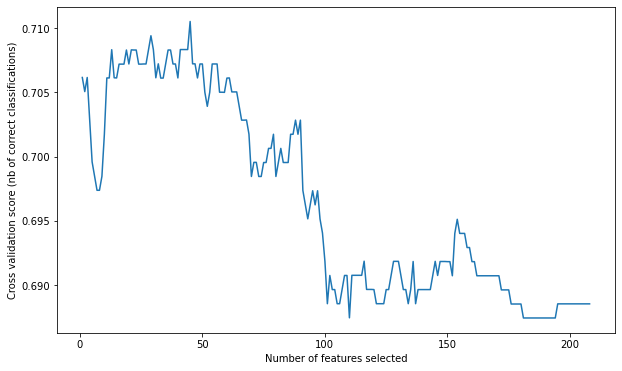

In [449]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df, y, test_size=0.20, random_state=22)

scaler = StandardScaler()
scaler.fit(X_train_2)

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(C=1, penalty='l2',solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(scaler.transform(X_train_2.fillna(0)), y_train_2)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


Optimal number of features: 30
Selected features: ['emea_role', 'support_role', 'Candidate_Current_Location_to_Candidate_Native_location', 'Client name_astrazeneca', 'Client name_hospira', 'Client name_standard_chartered_bank', 'Position to be closed_niche', 'Candidate Job Location_visakapatinam', 'Interview Venue_hosur', 'Candidate Native location_ahmedabad', 'Candidate Native location_baddi', 'Candidate Native location_chennai', 'Candidate Native location_nagercoil', 'Candidate Native location_noida', 'Candidate Native location_pondicherry', 'Candidate Native location_trivandrum', 'Have you obtained the necessary permission to start at the required time_no', 'Hope there will be no unscheduled meetings_not sure', 'Have you taken a printout of your updated resume. Have you read the JD and understood the same_no', 'Are you clear with the venue details and the landmark._no', 'Has the call letter been shared_no', 'Has the call letter been shared_yes', 'skillset_basesas_program_reporting',

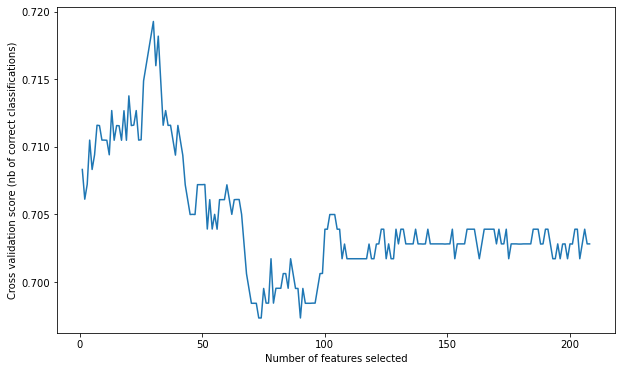

In [450]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(C=1, penalty='l1',solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(scaler.transform(X_train_2.fillna(0)), y_train_2)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [453]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Optimal number of features: 1
Selected features: ['Have you obtained the necessary permission to start at the required time_no']


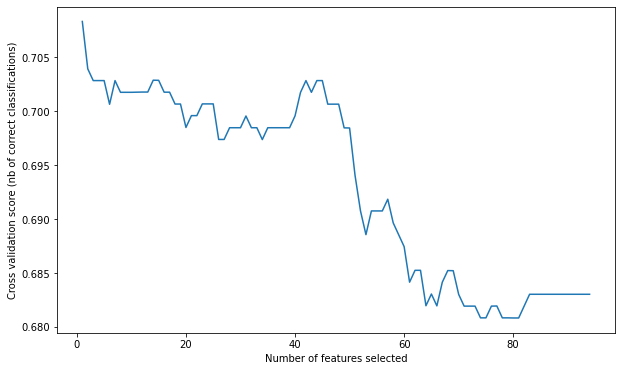

In [462]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(C=1, penalty='l2',solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(scaler.transform(X_train.fillna(0)), y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features: 32
Selected features: ['Have you obtained the necessary permission to start at the required time_no', 'Candidate Native location_hyderabad', 'Candidate Job Location_visakapatinam', 'Candidate Native location_noida', 'skillset_java_j2ee_struts_hibernate', 'skillset_java_j2ee_jsf', 'Candidate Job Location_noida', 'skillset_sccm_sharepoint', 'Interview Type_walkin', 'Has the call letter been shared_yes', 'Are you clear with the venue details and the landmark._yes', 'Position to be closed_niche', 'Candidate Native location_pondicherry', 'Position to be closed_production_sterile', 'Have you taken a printout of your updated resume. Have you read the JD and understood the same_no', 'Industry_it', 'Client name_williams_lea', 'Hope there will be no unscheduled meetings_not sure', 'skillset_ra_label', 'skillset_fresher', 'skillset_cots', 'support_role', 'Candidate Current Location_hyderabad', 'emea_role', 'skillset_lending_and_liablities', 'Has the call letter been sh

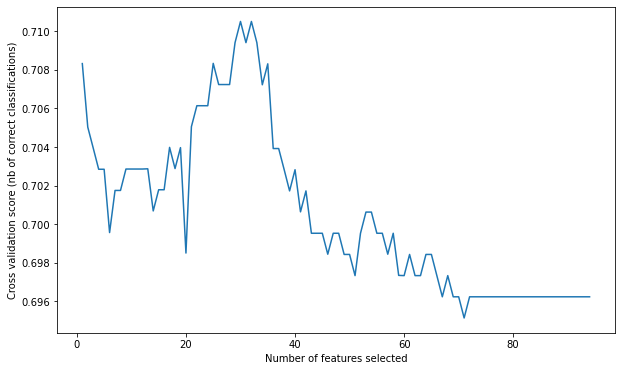

In [463]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(C=1, penalty='l1',solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(scaler.transform(X_train.fillna(0)), y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

The model using the sklearn column selection model preformed better than the one making use of MI and correlation. So, we'll go forward with that.

Testing to see how results are for if we only use the one column `Have you obtained the necessary permission to start at the required time_yes` to predict if candidates will show:

In [149]:
result = pd.concat([X_test['Have you obtained the necessary permission to start at the required time_yes'], y_test], axis=1)

In [150]:
#getting target into 1/0's
result["y"] =  result['Observed Attendance'].apply(lambda row: zeros_and_ones(row))

#getting if "predictions" were correct
result["correct"] = result['Have you obtained the necessary permission to start at the required time_yes'] == result["y"]

result['results'] = result.apply(lambda row: confusion_data(row),axis=1) #getting confusion matrix data

In [201]:
true_pos = sum(result['results'] == 'true_pos')
false_pos = sum(result['results'] == 'false_pos')

Tr = sum(result["correct"]==True)
F = sum(result["correct"]==False)

print(f"Accuracy is: {(Tr/(Tr+F))}")
print(f"Recall is: {(true_pos/(true_pos+false_pos))}")

Accuracy is: 0.6929824561403509
Recall is: 0.6682926829268293


In [466]:
scaler_2 = StandardScaler()
scaler_2.fit(X_train_2[best_cols])

StandardScaler()

In [492]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

best_cols = ['emea_role', 'support_role', 'Candidate_Current_Location_to_Candidate_Native_location', 
             'Client name_astrazeneca', 'Client name_hospira', 'Client name_standard_chartered_bank', 
             'Position to be closed_niche', 'Candidate Job Location_visakapatinam', 'Interview Venue_hosur',
             'Candidate Native location_ahmedabad', 'Candidate Native location_baddi', 
             'Candidate Native location_chennai', 'Candidate Native location_nagercoil', 
             'Candidate Native location_noida', 'Candidate Native location_pondicherry', 
             'Candidate Native location_trivandrum', 
             'Have you obtained the necessary permission to start at the required time_no', 
             'Hope there will be no unscheduled meetings_not sure', 
             'Have you taken a printout of your updated resume. Have you read the JD and understood the same_no', 
             'Are you clear with the venue details and the landmark._no', 
             'Has the call letter been shared_no', 'Has the call letter been shared_yes', 
             'skillset_basesas_program_reporting', 'skillset_biosimiliars', 'skillset_cots', 
             'skillset_cots_developer', 'skillset_etl', 'skillset_java_j2ee_jsf', 
             'skillset_java_j2ee_struts_hibernate', 'skillset_lending_and_liablities']


# 5 folds selected
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
model = LogisticRegression(C=1, penalty='l1',solver='liblinear',random_state=42)
results = cross_val_score(model, scaler_2.transform(X_train_2[best_cols].fillna(0)), y_train_2, cv=kfold)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 73.356% (3.255%)


In [493]:
model.fit(scaler_2.transform(X_train_2[best_cols].fillna(0)), y_train_2)
predicted = model.predict(scaler_2.transform(X_test_2[best_cols]))
matrix = confusion_matrix(y_test_2, predicted)
print(matrix)
print(f"Test Accuracy of the model: {model.score(scaler_2.transform(X_test_2[best_cols]), y_test_2)}")

[[ 27  62]
 [ 10 129]]
Test Accuracy of the model: 0.6842105263157895


In [494]:
confmtrx = np.array(matrix)
pd.DataFrame(confmtrx, index=['Predicted_Showing','Predicted_No_showing'],
columns=['Did Show', 'Did Not show', ])

,Did Show,Did Not show
Predicted_Showing,27,62
Predicted_No_showing,10,129


Predictions for the results from the missing data using the logistic regression model:

In [505]:
predicted_results = model.predict(scaler_2.transform(missing_dep[best_cols]))
pred_prob = model.predict_proba(scaler_2.transform(missing_dep[best_cols]))

In [528]:
# pd.concat([, missing_dep[best_cols]])
missing_dep['predicted_outcomes'] = predicted_results
missing_dep[['predicted_probabilities_no']] = np.array(pd.DataFrame(pred_prob)[0])
missing_dep[['predicted_probabilities_yes']] = np.array(pd.DataFrame(pred_prob)[1])
# pd.DataFrame(pred_prob)

In [530]:
missing_vals = pd.merge(missing_dep,here, left_index=True, right_index=True)

In [534]:
model_preds = missing_vals[['Name(Cand ID)','predicted_outcomes','predicted_probabilities_no','predicted_probabilities_yes']]

In [535]:
model_preds.to_csv('model_predictions.csv')

predictions just using the `Have you obtained the necessary permission to start at the required time_yes` feature:

In [536]:
single_var_pred = missing_dep.copy()
single_var_pred['predicted_outcomes']=single_var_pred['Have you obtained the necessary permission to start at the required time_yes']

In [537]:
single_var_pred['predicted_probability'] = 0.69

In [538]:
missing_vals_2 = pd.merge(single_var_pred,here, left_index=True, right_index=True)

In [584]:
missing_vals_2['predicted_prob_show'] = missing_vals_2['predicted_probability'].apply(lambda row: get_prob(row))

In [585]:
missing_vals_2[['Name(Cand ID)','predicted_outcomes','predicted_prob_show']].to_csv('single_feature_prediction.csv')

Model feature importance:

In [547]:
importance = model.coef_


Feature: 0, Score: [ 0.22464837  0.26702582 -0.24360507 -0.19067364 -0.49607445 -0.30239482
  0.38306451  0.46990652 -0.18502839  0.15954868 -0.1671272  -0.2472979
 -0.15410901  0.29068804  0.20140284  0.175641   -0.7881427  -0.27501336
 -0.35735209 -0.24062431 -0.1132756   0.15123241  0.24835737  0.20219397
  0.14547165 -0.2675775   0.29872383 -0.16935556  0.1390158   0.18363005]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
l = ['Economic_Need_Index', 'Percent_ELL', 'Percent_Asian', 'Percent_Black',
       'Percent_Hispanic', 'Percent_Black_Hispanic', 'Percent_White',
       'Student_Attendance_Rate', 'Percent_of_Students_Chronically_Absent',
       'Rigorous_Instruction_Per', 'Collaborative_Teachers_Per',
       'Supportive_Environment_Per', 'Strong_Family_Community_Ties_Per']
titles_select = l
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(40,10))

for i in range(2):
    for j in range(7):
        k = sum([6 if i == 1 else 0])
        n = (k+j)
        sns.regplot(x=titles_select[n],y='Total_Proficiency_Average',fit_reg = True, scatter =True,data=kaggle_data_df_short, ax=axes[i][j])
# # for i in range(len(titles_select)):
#     kaggle_data_df_short.plot.scatter(x=titles_select[i], y='Total Proficiency Average', ax=axes[i], alpha=0.4, color='b')
plt.savefig('Faetures_to_Proficiency_subplots.png')

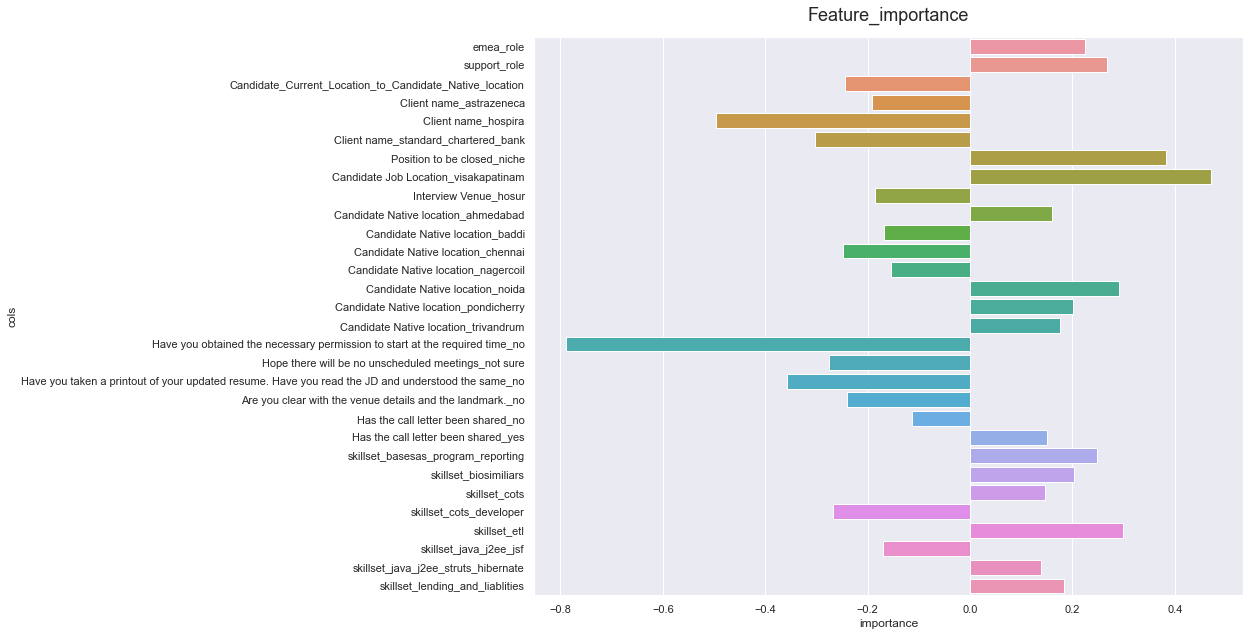

In [580]:
# get importance
importance = model.coef_
# summarize feature importance
feature_impt = pd.DataFrame({"cols":best_cols,'importance':importance[0]})

sns.set(rc={'figure.figsize':(12.7,10.27)})
bar = sns.barplot(data=feature_impt, x="importance", y="cols")
bar.set_title('Feature_importance', fontdict={'fontsize':18}, pad=16);

### learnings and Ideas:

Really the biggest indicator, *and low-tech/low-cost way*, of detemining if a candidate will show up to an interview is simply getting a confirmation from them and permission to start at the time indicated. If we go simply by this method, then we will know 69% of the time. That rate is slightly worse than what these models provide, however when it comes to cost to get the results I believe there's a lot of power in this method.

In this way, I believe the company should focus on making sure they reachout to candidate before interviews to make sure they get a confirmation. Obviosuly there are events that cannot be forseen, this method could also possibly be improved upon if there were follow-ups or if there was a calendar invite option. I believe these two could potentially result in higher accuracy if we tested these as other steps to follow before an interview.

The models could defitily see improvements with time, more cleaning, and feature engineering. I am sure it could get above that threshold. But it may be a better use of resources to focus on confirmations and engaging with candidates. The model does have the added benefit of giving the probability expected, which I do not provide with the simple method.


### Intrepretation:

A client has scored a candidate with your model and it gave the candidate a 30% chance of attending the interview. However, the candidate did come to the interview. The client would like to know why there is this apparent discrepancy in your model. 

How would you explain this occurrence? What would you have ideally done to prevent this confusion with the client? 

Do your accuracy metrics help explain this? 

Could you provide a better way for the client to evaluate your model's performance?

What accuracy metrics would help explain this gap in understanding?

The percentage given is an expectation based on the data about the candidates that we are provided. The model can take in that informaton and learn what it thinks are indicators of a candidate actually attending an interview. However, these are essentially averages in a sense. There are big and small factors that can really throw off the predictions. Suppose this candidate wasn't confirmed with or the data wasn't updated in the database, then that would have a very large impact on what the model outputs, and may predict the user to be much less likely of coming to the interview. I think one really great way to prevent this confusion is to make these predictions visual. Providing your results in a dashboard, or GUI that can provide more context or have opportinites for understanding the data better is always a great option for something like this. Showing what is important for the model, and possibly for this user speicifcally. If there are certain factors that are pushing our candidate into the "no" outcome, we could flag those. This may be a way of helping the team ensure they are doing their part.

The metric we've provided is using accuracy, out of all of the predictions we have how many times were we actually correct. In this case, we are incorrect in our predictions 30% of the time. Sometimes it's due to unforseeable impacts on the day/week of the interview, and othertimes it's becuase the model can accidentaly predict the wrong outcome.

If there are wrong predictions, it would be great to keep track of what features seem to be causing this, and also check on the client provided responses--as a few of these have a big imapct on the model itself. So, if they aren't being reponded to then it could be tipping the model results. I would start by evaluating what is happening more often, candidates are predicted to be no-shows but do show (false negatives) or candidates are predicted to show but do not. This will help us detemine how it's skewed, but may also bring insignt in the client process and how these two can work better together.

There are other evaluation metrics we could use, but it is dependent upon what errors impact this team the most. If prediting a candidate as a possible no-show, and having them show up is a bigger issue than predicting a candidte to show up and then they don't, then I think the metric we would want to move forward with is recall. **Recall** simply gives us the rate of how many times we've said someone will show, over how many times they actually show (we said they would show/everyone who shows). If however, the opposite is true and it's more of an inconvenience for us to say they will not show when they do, then we need to us **Precision**. Precision shows us how many times we were correct out of all of the times we said someone would show (including no-shows). Once we determine which metric is better for the team, then it would be great to retrain with those in mind.